# CNN - Transfer Learning with AlexNet and GoogleNet

### Run this part in running Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
import os
# cd drive/MyDrive/Colab\ Notebooks/project
os.chdir('drive/MyDrive/project')
# os.chdir('drive/MyDrive/Colab Notebooks/project')


### Set Up

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import glob
from torchvision import models
from torchsummary import summary

import numpy as np

from function import get_mean_and_std, imageloader, get_basic_transforms, get_augmented_transforms, \
    predict_label, compute_loss, get_optimizer, ModifiedAlexNet, ModifiedGoogleNet, Trainer


%load_ext autoreload
%autoreload 2

In [3]:
# Checking if we have GPU
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available()
print("GPU available:", is_cuda)

GPU available: False


In [4]:
data_base_path = 'data/' 
data_train_path ='data/train/' 
data_test_path = 'data/test/'
data_val_path = 'data/val/'
model_base_path = 'model_checkpoints/'


In [5]:
print(os.listdir(data_base_path))
print(os.listdir(data_train_path))
print(os.listdir(data_test_path))
print(os.listdir(data_val_path))


['.DS_Store', 'test', '__MACOSX', 'train', 'val']
['.DS_Store', 'PNEUMONIA', 'NORMAL']
['.DS_Store', 'PNEUMONIA', 'NORMAL']
['.DS_Store', 'PNEUMONIA', 'NORMAL']


### Obtaining Mean and Standard Deviation from the Dataset

In [6]:
# dataset_mean, dataset_std = get_mean_and_std(data_base_path)
dataset_mean = 0.48738179
dataset_std = 0.2454088

In [7]:
print(f'Dataset mean = {dataset_mean}, standard deviation = {dataset_std}')

Dataset mean = 0.48738179, standard deviation = 0.2454088


### Loading the Data

In [8]:
input_size = (64, 64)
train_dataset = imageloader(data_train_path, 
                            transform = get_augmented_transforms(input_size, dataset_mean, dataset_std))
test_dataset = imageloader(data_test_path, 
                            transform = get_basic_transforms(input_size, dataset_mean, dataset_std))

In [9]:
print(f"number of training images: {len(train_dataset)}")
print(f"number of training images: {len(test_dataset)}")

number of training images: 5216
number of training images: 624


In [10]:
print(f"Classes: {train_dataset.class_dict}")

Classes: {'PNEUMONIA': 0, 'NORMAL': 1}


In [11]:
sample_image, sample_label = next(iter(train_dataset))
print("data type of sample_image : {}".format(type(sample_image)))
print("sample label : {}".format(sample_label))

data type of sample_image : <class 'torch.Tensor'>
sample label : 0


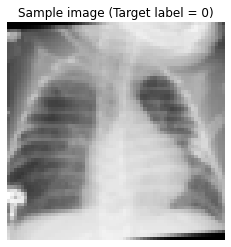

In [12]:
fig, axs = plt.subplots()
axs.imshow(sample_image.squeeze().numpy(), cmap='gray')
axs.axis('off')
axs.set_title(f'Sample image (Target label = {sample_label})')
plt.show()

### Training Pretrained AlexNet

In [ ]:
optimizer_config = {
  "optimizer_type": "AdamW",
  "lr": 3e-3,
  "weight_decay": 1e-5,
  "momentum": None,
}

In [ ]:
#Architecture of the Modified AlexNet
alexnet = ModifiedAlexNet()
alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

ModifiedAlexNet(
  (loss_criterion): CrossEntropyLoss()
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): AdaptiveAvgPool2d(output_size=(6, 6))
    (14): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout

In [ ]:
# summary(alexnet.cuda(), (1, 224, 224))

In [ ]:

optimizer = get_optimizer(alexnet, optimizer_config)
input_size = (224, 224)

trainer = Trainer(train_data_dir=data_train_path,
                  test_data_dir = data_test_path, 
                  model = alexnet,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'alexnet'),
                  train_data_transforms = get_augmented_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_basic_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda)


In [ ]:
trainer.train(num_epochs=4)

Epoch:0, Training Loss:0.1922, Validation Loss:0.3300
Epoch:1, Training Loss:0.1658, Validation Loss:0.8669
Epoch:2, Training Loss:0.0987, Validation Loss:0.4181
Epoch:3, Training Loss:0.0901, Validation Loss:0.2732
Epoch:4, Training Loss:0.0808, Validation Loss:0.2740


In [ ]:
# trainer.train(num_epochs=5)

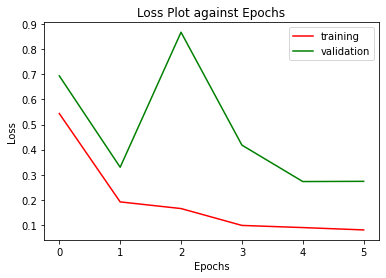

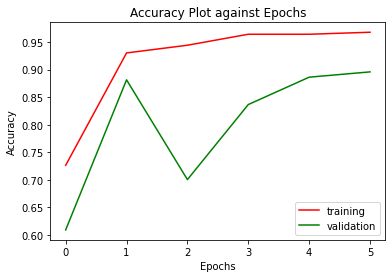

In [ ]:
trainer.plot_loss()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_list
validation_accuracy = trainer.validation_accuracy_list

print(f'Training Accuracy: {train_accuracy[-1]}\n')

print(f'Validation Accuracy: {validation_accuracy[-1]}')

Training Accuracy: 0.9677914110429447

Validation Accuracy: 0.8958333333333334


In [ ]:
validation_accuracy

[0.6089743589743589,
 0.8814102564102564,
 0.7003205128205128,
 0.8365384615384616,
 0.8862179487179487,
 0.8958333333333334]

In [ ]:
train_accuracy

[0.7262269938650306,
 0.9302147239263804,
 0.9442101226993865,
 0.964148773006135,
 0.964148773006135,
 0.9677914110429447]

In [ ]:
precision, recall, f1 = trainer.final_evaluate()
print(f'Precision:{precision}\n')
print(f'Recall:{recall}\n')
print(f'F1 score:{f1}\n')

Confusion Matrix for the Trained Model
[[372  18]
 [ 56 178]] 

Precision:0.9081632653061225

Recall:0.7606837606837606

F1 score:0.8279069767441861



In [ ]:
# # Corrected Accuracy Plots (corrected y-axis labels)
# validation_accuracy =[0.4951923076923077,
#  0.7147435897435898,
#  0.8477564102564102,
#  0.7996794871794872,
#  0.6650641025641025,
#  0.9006410256410257]

# train_accuracy = [0.5709355828220859,
#  0.941909509202454,
#  0.9022239263803681,
#  0.9551380368098159,
#  0.937691717791411,
#  0.9664493865030674]

# plt.figure()
# count_epoch = range(len(train_accuracy))

# plt.plot(count_epoch, train_accuracy, '-r', label = 'training')
# plt.plot(count_epoch, validation_accuracy, '-g', label = 'validation')
# plt.title("Accuracy Plot against Epochs")
# plt.legend()
# plt.ylabel("Accuracy")
# plt.xlabel("Epochs")
# plt.show()

### Training GoogleNet (with Inception Layers)

In [13]:
# from torchvision.models import googlenet

In [14]:
googlenet = ModifiedGoogleNet()
# googlenet

In [15]:
# summary(googlenet.cuda(), (1, 224, 224))

In [16]:
# for parameters in googlenet.model.inception5b.parameters():
#     print(parameters.requires_grad)

In [17]:
# for module in googlenet.modules():
#     print(module.parameters)

In [18]:
#Total Traininable Parameters
total_traininable_params = 0
for param in googlenet.parameters():
    if param.requires_grad == True:
        #print(param.numel())
        total_traininable_params += param.numel()
total_traininable_params

3131874

In [19]:
optimizer_config = {
  "optimizer_type": "SGD",
  "lr": 3e-3,
  "weight_decay": 1e-5,
  "momentum": 0.9,
}

In [20]:
optimizer = get_optimizer(googlenet, optimizer_config)
input_size = (224, 224)

trainer = Trainer(train_data_dir=data_train_path,
                  test_data_dir = data_test_path, 
                  model = googlenet,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'googlenet'),
                  train_data_transforms = get_augmented_transforms(input_size, dataset_mean, dataset_std),
                  test_data_transforms = get_basic_transforms(input_size, dataset_mean, dataset_std),
                  batch_size = 64,
                  load_from_disk = False,
                  cuda = is_cuda)


In [21]:
trainer.train(num_epochs=3)

Epoch:0, Training Loss:0.6552, Validation Loss:0.6962
Epoch:1, Training Loss:0.1313, Validation Loss:0.3148
Epoch:2, Training Loss:0.0895, Validation Loss:0.2883
Epoch:3, Training Loss:0.0710, Validation Loss:0.2821


KeyboardInterrupt: 

In [27]:
#1 additional epoch on top of the previous 6 epoch
trainer.train(num_epochs=2)

Epoch:0, Training Loss:0.0560, Validation Loss:0.3009
Epoch:1, Training Loss:0.0502, Validation Loss:0.2625
Epoch:2, Training Loss:0.0421, Validation Loss:0.2401


In [28]:
#1 additional epoch on top of the previous 6 epoch
# trainer.train(num_epochs=2)

In [29]:
#1 additional epoch on top of the previous 6 epoch
# trainer.train(num_epochs=3)

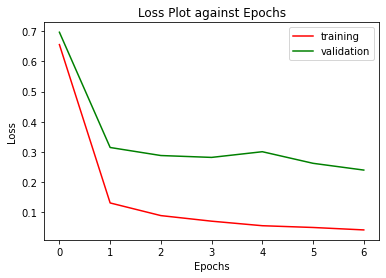

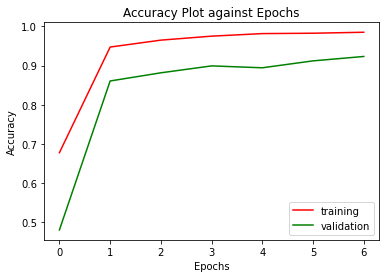

In [30]:
trainer.plot_loss()
trainer.plot_accuracy()

In [31]:
train_accuracy = trainer.train_accuracy_list
validation_accuracy = trainer.validation_accuracy_list

print(f'Training Accuracy: {train_accuracy[-1]}\n')

print(f'Validation Accuracy: {validation_accuracy[-1]}')

Training Accuracy: 0.9848542944785276

Validation Accuracy: 0.9230769230769231


In [32]:
validation_accuracy

[0.4807692307692308,
 0.8605769230769231,
 0.8814102564102564,
 0.8990384615384616,
 0.8942307692307693,
 0.9118589743589743,
 0.9230769230769231]

In [25]:
train_accuracy

[0.6777223926380368,
 0.9470858895705522,
 0.9647239263803681,
 0.9748849693251533]

In [33]:
precision, recall, f1 = trainer.final_evaluate()
print(f'Precision:{precision}\n')
print(f'Recall:{recall}\n')
print(f'F1 score:{f1}\n')

Confusion Matrix for the Trained Model
[[383   7]
 [ 41 193]] 

Precision:0.965

Recall:0.8247863247863247

F1 score:0.8894009216589861



In [ ]:
# # Corrected Accuracy Plots (corrected y-axis labels)
# validation_accuracy =[0.3541666666666667,
#  0.7628205128205128,
#  0.8669871794871795,
#  0.8862179487179487,
#  0.8894230769230769,
#  0.8942307692307693,
#  0.8926282051282052,
#  0.8926282051282052,
#  0.9006410256410257,
#  0.9006410256410257,
#  0.9134615384615384,
#  0.9134615384615384,
#  0.907051282051282,
#  0.907051282051282,
#  0.8974358974358975,
#  0.8974358974358975,
#  0.9150641025641025]

# train_accuracy = [0.43920829406220546,
#  0.8327049952874647,
#  0.9472196041470311,
#  0.9580584354382657,
#  0.9622997172478793,
#  0.967483506126296,
#  0.9754948162111216,
#  0.9754948162111216,
#  0.9797360980207351,
#  0.9792648444863337,
#  0.9778510838831291,
#  0.9802073515551367,
#  0.9844486333647502,
#  0.9830348727615457,
#  0.9891611687087654,
#  0.9877474081055608,
#  0.9858623939679547]

# plt.figure()
# count_epoch = range(len(train_accuracy))

# plt.plot(count_epoch, train_accuracy, '-r', label = 'training')
# plt.plot(count_epoch, validation_accuracy, '-g', label = 'validation')
# plt.title("Accuracy Plot against Epochs")
# plt.legend()
# plt.ylabel("Accuracy")
# plt.xlabel("Epochs")
# plt.show()